In [1]:
import sys
%reload_ext autoreload
%autoreload 2

from tqdm.auto import tqdm

from mcfacts.inputs.settings_manager import SettingsManager, AGNDisk
from mcfacts.modules.accretion import ProgradeBlackHoleAccretion, BinaryBlackHoleAccretion, ProgradeBlackHoleBondi
from mcfacts.modules.damping import ProgradeBlackHoleDamping, BinaryBlackHoleDamping
from mcfacts.modules.disk_capture import EvolveRetrogradeBlackHoles, RecaptureBinaryBlackHoles, \
    CaptureNSCProgradeBlackHoles
from mcfacts.modules.dynamics import SingleBlackHoleDynamics, BinaryBlackHoleDynamics, BinaryBlackHoleIonization
from mcfacts.modules.formation import BinaryBlackHoleFormation
from mcfacts.modules.gas_hardening import BinaryBlackHoleGasHardening
from mcfacts.modules.gw import BinaryBlackHoleEvolveGW, InnerBlackHoleDynamics
from mcfacts.modules.merge import ProcessBinaryBlackHoleMergers, ProcessEMRIMergers
from mcfacts.modules.migration import ProgradeBlackHoleMigration, BinaryBlackHoleMigration
from mcfacts.objects.actors import InitialBlackHoleReclassification, InnerDiskFilter, FlipRetroProFilter, InitialStarReclassification
from mcfacts.objects.actors.reality_checks import SingleBlackHoleRealityCheck, BinaryBlackHoleRealityCheck
from mcfacts.objects.agn_object_array import *
from mcfacts.objects.galaxy import Galaxy
from mcfacts.objects.populators import SingleBlackHolePopulator, SingleStarPopulator
from mcfacts.objects.snapshot import TxtSnapshotHandler
from mcfacts.objects.timeline import SimulationTimeline

# Seed should be 128 bits long to ensure random has enough entropy (as per NumPy documentation)
#
# import secrets
# secret.randombits(128)

settings = SettingsManager({
    "verbose": False,
    "override_files": True,
    "save_state": True,
    "save_each_timestep": True,
    "disk_inner_stable_circ_orb": 16,
    "galaxy_num": 100,
    "output_dir": '../ExampleRuns/NewGTRuns/newseed',
    "active_timestep_num":100,
    "overwrite_files":True,
    "flag_use_pagn": True,
    "seed":54868812644729562268856706214161065189
})

population_cabinet = FilingCabinet()

agn_disk = AGNDisk(settings)
snapshot_handler = TxtSnapshotHandler(settings)

n_galaxy = 100

pbar = tqdm(total=n_galaxy, position=0, leave=True)

for galaxy_id in range(settings.galaxy_num,):
    pbar.set_description(f"Running Galaxy {galaxy_id}")
    pbar.update(1)

    galaxy_seed = settings.seed - galaxy_id

    # Create instance of galaxy
    galaxy = Galaxy(seed=galaxy_seed, runs_folder="./runs", galaxy_id=str(galaxy_id), settings=settings)

    # Create instance of populators
    single_bh_populator = SingleBlackHolePopulator()
    single_star_populator = SingleStarPopulator()
    galaxy.populate([single_bh_populator, single_star_populator], agn_disk)

    # Create timeline to classify objects created during population
    pre_timeline = SimulationTimeline("Reclassification", timesteps=1, timestep_length=0)

    # Run stars reclassification first, since it can convert stars to bh under certain conditions
    pre_timeline.add_timeline_actor(InitialStarReclassification())
    pre_timeline.add_timeline_actor(InitialBlackHoleReclassification())
    pre_timeline.add_timeline_actor(SingleBlackHoleRealityCheck())

    galaxy.run(pre_timeline, agn_disk)

    # Create timeline to run main simulation
    active_phase_timeline = SimulationTimeline("Active Timeline",
                                           timesteps=settings.active_timestep_num,
                                           timestep_length=galaxy.settings.active_timestep_duration_yr)

    # Retrograde evolution and capture
    active_phase_timeline.add_timeline_actor(EvolveRetrogradeBlackHoles())
    active_phase_timeline.add_timeline_actor(FlipRetroProFilter())

    # NSC Capture
    active_phase_timeline.add_timeline_actor(CaptureNSCProgradeBlackHoles())
    active_phase_timeline.add_timeline_actor(SingleBlackHoleRealityCheck())

    active_phase_timeline.add_timeline_actor(InnerDiskFilter())

    prograde_array = galaxy.settings.bh_prograde_array_name
    innerdisk_array = galaxy.settings.bh_inner_disk_array_name
    inner_gw_only_array = galaxy.settings.bh_inner_gw_array_name

    # Migration: Single BH, Binary BH
    active_phase_timeline.add_timeline_actors([
        ProgradeBlackHoleMigration(target_array=innerdisk_array),
        ProgradeBlackHoleMigration(target_array=prograde_array),
        BinaryBlackHoleMigration()
    ])

    # Accretion: Single BH, Binary BH,
    if settings.flag_enable_bondi:
        accretion = [
            ProgradeBlackHoleBondi(target_array=innerdisk_array),
            ProgradeBlackHoleBondi(target_array=prograde_array),
        ]
    else:
        accretion = [
            ProgradeBlackHoleAccretion(target_array=innerdisk_array),
            ProgradeBlackHoleAccretion(target_array=prograde_array),
        ]

    active_phase_timeline.add_timeline_actors(accretion)
    active_phase_timeline.add_timeline_actor(BinaryBlackHoleAccretion(reality_merge_checks=True),)

    # Gas Dynamics: Single BH, Binary BH
    active_phase_timeline.add_timeline_actors([
        ProgradeBlackHoleDamping(target_array=innerdisk_array),
        ProgradeBlackHoleDamping(target_array=prograde_array),
        BinaryBlackHoleDamping(),
        BinaryBlackHoleGasHardening(reality_merge_checks=True)
    ])

    # Dynamical Encounters: Single BH, Binary BH
    active_phase_timeline.add_timeline_actors([
        SingleBlackHoleDynamics(target_array=innerdisk_array),
        InnerBlackHoleDynamics(target_array=innerdisk_array),
        InnerBlackHoleDynamics(target_array=inner_gw_only_array),
        SingleBlackHoleDynamics(target_array=prograde_array),
        BinaryBlackHoleDynamics(reality_merge_checks=True)
    ])

    # Misc Evolution: Binary BH
    active_phase_timeline.add_timeline_actors([
        RecaptureBinaryBlackHoles(),
        BinaryBlackHoleRealityCheck(),
        BinaryBlackHoleEvolveGW(),
        ProcessBinaryBlackHoleMergers(),
        BinaryBlackHoleFormation(),
        BinaryBlackHoleIonization()
    ])

    # EMRI Dynamics: Single BH (inner disk)
    active_phase_timeline.add_timeline_actor(ProcessEMRIMergers())

    galaxy.run(active_phase_timeline, agn_disk)

    population_cabinet.ignore_check_array("blackholes_merged")
    population_cabinet.ignore_check_array("blackholes_lvk")

    bbh_merged_array = galaxy.settings.bbh_merged_array_name
    bbh_lvk_array = galaxy.settings.bbh_gw_array_name
    emri_merged_array = galaxy.settings.emri_array_name

    if bbh_merged_array in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_merged",galaxy.filing_cabinet.get_array(bbh_merged_array))

    if bbh_lvk_array in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_lvk", galaxy.filing_cabinet.get_array(bbh_lvk_array))

    if innerdisk_array in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_emri", galaxy.filing_cabinet.get_array(innerdisk_array))

    if inner_gw_only_array in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_emri", galaxy.filing_cabinet.get_array(inner_gw_only_array))

    if emri_merged_array in galaxy.filing_cabinet:
        population_cabinet.create_or_append_array("blackholes_emri", galaxy.filing_cabinet.get_array(emri_merged_array))

pbar.close()

/Users/jakepost/miniforge3/envs/mcfacts-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e+00 MSun/yr
le = 1.0
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.01
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=3502 (R=9.06e+02 Rs)
Beginning star formation at index 3502
Mdisk = 422372550.2716628 Msun
Mdisk/Mbh = 4.223725502716627


Running Galaxy 0:   0%|          | 0/100 [00:00<?, ?it/s]

[39474.4026964  21712.06666807 38114.41455441 28298.23282023
 32657.66398566 40465.13478513 40805.64425964 10083.85059185
 39106.54647655 46203.9017899  19463.68425768 22614.60925261
 19459.78472178 44169.14395514 36681.83505184 17251.74750975
 35293.8002478  12288.08825609 41692.28873629 49706.38494438
 16066.23860224 40290.65555066 35900.02809803 43191.71028371
 47421.40688941 40009.28903729 14927.37414337 32633.56685357
 31385.96533597 18865.00550901 29389.9028959  28734.98084098
  7701.68410368 12137.44111384 28369.47434147  1051.92551993
 37512.08624009 39416.60957461 49448.11568212  6590.56634257
 26957.79235179 43228.70588071 24114.88069888 29931.93838594
 25409.87657588 22881.77745578  9681.5984656  34275.72141372
 40234.61222061 47960.69270669 22684.25096425  2941.25066325
 31614.43814444 26497.94707995 37816.84996885 42231.27458927
  6725.85024185 41691.38884339 16822.0986441   4273.29213129
 29694.11669012  6382.09115409 29264.81778282 44345.37298137
 38595.10734511  2301.58

Running Galaxy 1:   2%|▏         | 2/100 [00:01<01:06,  1.47it/s]

[25974.87385755 31389.78575034 37068.10752712 41186.3512916
 15155.9163917  40457.44637832 15799.73567194 38420.15280134
 39821.10456929 26154.68241541 48759.1176481  40452.0774413
 16521.49028438 25633.32132489 45971.61506607 15596.74363151
 18291.97083888 39490.03090783 22064.16414656 27331.57403491
 44010.21794102 10626.25198808 15620.56001382 28570.84819796
 32493.48847912 20809.38725526 31715.91090939 34565.27590358
   454.87416441 27187.41890915 49997.974504   17810.59138677
 28750.11948829 29172.4964984  40388.480447   16123.2217416
 30714.8143949  44920.58983801 11007.43705626 37528.70834058
 15039.78824763 33479.1134387  41899.38208507 13923.24553282
 26050.85707934 49121.47848269 22229.05996217 48152.23028044
 26724.36942253 19437.90198794 14896.04754699 39982.14763183
 11622.45837447 40694.02602234 20445.08763646  1207.59695513
 32916.59202988 39200.10541311 21500.68561783 19074.36307047
 18017.76378442 49681.19150867 49923.52567963 21709.88591561
 23209.88024171 41094.24818

AssertionError: disk_bh_pro_orbs_a contains values greater than disk_radius_outer[50153.8120777]

In [3]:
snapshot_handler = TxtSnapshotHandler(settings)

snapshot_handler.save_cabinet("./runs", "population", population_cabinet)

In [4]:
import matplotlib.ticker as mticker
import numpy as np
from scripts.population_plots import linefunc
from scipy.optimize import curve_fit

from mcfacts.vis import styles
from mcfacts.vis import plotting

figsize = "apj_col"

def make_gen_masks(gen_obj1, gen_obj2):
    """Create masks for retrieving different sets of a merged or binary population based on generation.
    """
    # Column of generation data

    # Masks for hierarchical generations
    # g1 : all 1g-1g objects
    # g2 : 2g-1g and 2g-2g objects
    # g3 : >=3g-Ng (first object at least 3rd gen; second object any gen)
    # Pipe operator (|) = logical OR. (&)= logical AND.
    g1_mask = (gen_obj1 == 1) & (gen_obj2 == 1)
    g2_mask = ((gen_obj1 == 2) | (gen_obj2 == 2)) & ((gen_obj1 <= 2) & (gen_obj2 <= 2))
    gX_mask = (gen_obj1 >= 3) | (gen_obj2 >= 3)

    return g1_mask, g2_mask, gX_mask

mergers = population_cabinet.get_array("blackholes_merged")
mass_final = mergers.mass_final

merger_g1_mask, merger_g2_mask, merger_gX_mask = make_gen_masks(mergers.gen_1, mergers.gen_2)

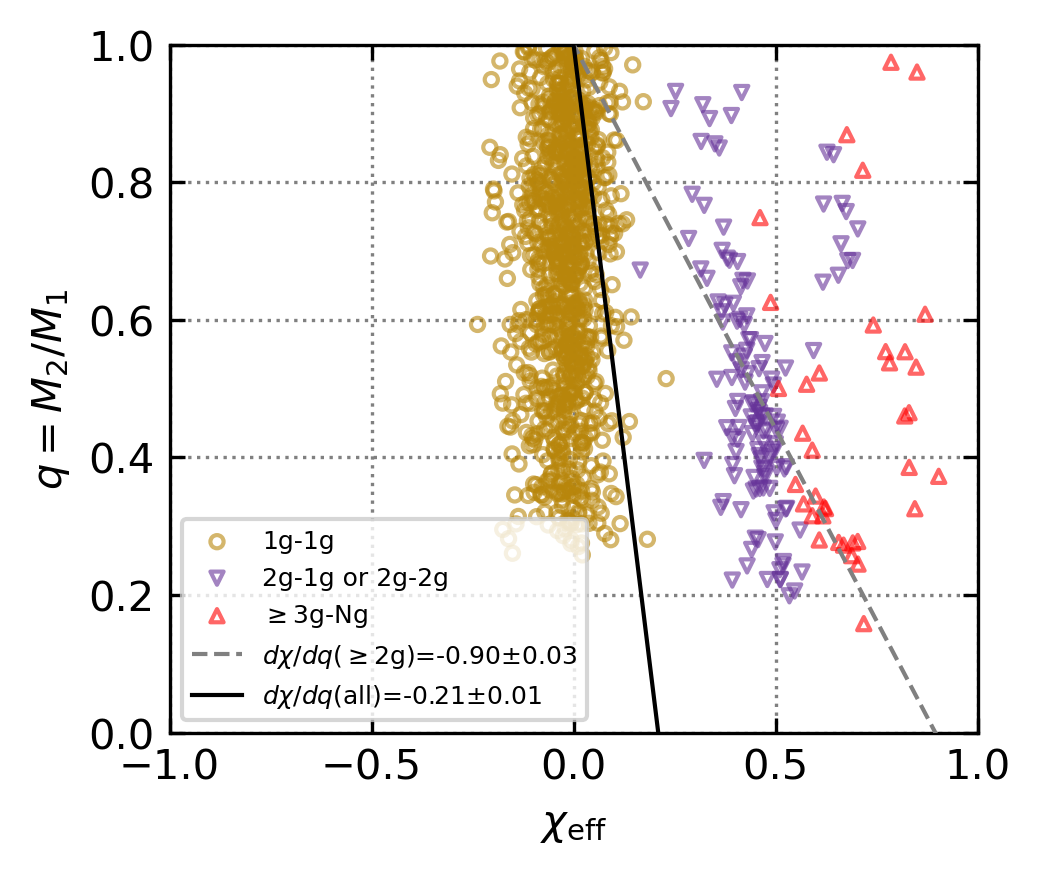

In [5]:
# retrieve component masses and mass ratio
m1 = np.zeros(len(mergers))
m2 = np.zeros(len(mergers))
mass_ratio = np.zeros(len(mergers))

for i in range(len(mergers)):
    if mergers.mass_1[i] < mergers.mass_2[i]:
        m1[i] = mergers.mass_1[i]
        m2[i] = mergers.mass_2[i]
    else:
        m1[i] = mergers.mass_2[i]
        m2[i] = mergers.mass_1[i]

    mass_ratio[i] = m1[i] / m2[i]

# (q,X_eff) Figure details here:
# Want to highlight higher generation mergers on this plot
chi_eff = mergers.chi_eff

# Get 1g-1g population
gen1_chi_eff = chi_eff[merger_g1_mask]
gen1_mass_ratio = mass_ratio[merger_g1_mask]
# 2g-1g and 2g-2g population
gen2_chi_eff = chi_eff[merger_g2_mask]
gen_mass_ratio = mass_ratio[merger_g2_mask]
# >=3g-Ng population (i.e., N=1,2,3,4,...)
genX_chi_eff = chi_eff[merger_gX_mask]
genX_mass_ratio = mass_ratio[merger_gX_mask]
# all 2+g mergers; H = hierarchical
genH_chi_eff = chi_eff[(merger_g2_mask + merger_gX_mask)]
genH_mass_ratio = mass_ratio[(merger_g2_mask + merger_gX_mask)]

# points for plotting line fit
x = np.linspace(-1, 1, num=2)

# fit the hierarchical mergers (any binaries with 2+g) to a line passing through 0,1
# popt contains the model parameters, pcov the covariances
# poptHigh, pcovHigh = curve_fit(linefunc, high_gen_mass_ratio, high_gen_chi_eff)

# plot the 1g-1g population
fig = plt.figure(figsize=(plotting.set_size(figsize)[0], 2.8))
ax2 = fig.add_subplot(111)
# 1g-1g mergers
ax2.scatter(gen1_chi_eff, gen1_mass_ratio,
            s=styles.markersize_gen1,
            marker=styles.marker_gen1,
            edgecolor=styles.color_gen1,
            facecolor='none',
            alpha=styles.markeralpha_gen1,
            label='1g-1g'
            )

# plot the 2g+ mergers
ax2.scatter(gen2_chi_eff, gen_mass_ratio,
            s=styles.markersize_gen2,
            marker=styles.marker_gen2,
            edgecolor=styles.color_gen2,
            facecolor='none',
            alpha=styles.markeralpha_gen2,
            label='2g-1g or 2g-2g'
            )

# plot the 3g+ mergers
ax2.scatter(genX_chi_eff, genX_mass_ratio,
            s=styles.markersize_genX,
            marker=styles.marker_genX,
            edgecolor=styles.color_genX,
            facecolor='none',
            alpha=styles.markeralpha_genX,
            label=r'$\geq$3g-Ng'
            )

if len(genH_chi_eff) > 0:
    poptHier, pcovHier = curve_fit(linefunc, genH_mass_ratio, genH_chi_eff)
    errHier = np.sqrt(np.diag(pcovHier))[0]
    # plot the line fitting the hierarchical mergers
    ax2.plot(linefunc(x, *poptHier), x,
             ls='dashed',
             lw=1,
             color='gray',
             zorder=3,
             label=r'$d\chi/dq(\geq$2g)=' +
                   f'{poptHier[0]:.2f}' +
                   r'$\pm$' + f'{errHier:.2f}'
             )
    #         #  alpha=linealpha,

if len(chi_eff) > 0:
    poptAll, pcovAll = curve_fit(linefunc, mass_ratio, chi_eff)
    errAll = np.sqrt(np.diag(pcovAll))[0]
    ax2.plot(linefunc(x, *poptAll), x,
             ls='solid',
             lw=1,
             color='black',
             zorder=3,
             label=r'$d\chi/dq$(all)=' +
                   f'{poptAll[0]:.2f}' +
                   r'$\pm$' + f'{errAll:.2f}'
             )

ax2.set(
    ylabel=r'$q = M_2 / M_1$',  # ($M_1 > M_2$)')
    xlabel=r'$\chi_{\rm eff}$',
    ylim=(0, 1),
    xlim=(-1, 1),
    axisbelow=True
)

if figsize == 'apj_col':
    ax2.legend(loc='lower left', fontsize=6)
elif figsize == 'apj_page':
    ax2.legend(loc='lower left')

ax2.grid('on', color='gray', ls='dotted')